<a href="https://colab.research.google.com/github/ismak10/Prediccion-de-demanda/blob/main/TFM_graficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicción de la demanda de energía mediante modelos de Machine Learning**

Ismael Kastillo

---
# Inicialización
---

In [51]:
# Imports generales
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import random
seed = 7
random.seed(seed)
np.random.seed(seed)
colores = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]

In [52]:
pip install --upgrade nbformat

In [53]:
# Subir el conjunto de datos de la demanda eléctrica en España 2019-2024
url = "https://raw.githubusercontent.com/ismak10/Prediccion-de-demanda/main/demanda.csv"
demanda = pd.read_csv(url)
print(demanda.shape)
demanda.head()

(47088, 3)


,Time (UTC),Day-ahead forecast,Actual load
0,16.02.2019 00:00,25924.0,25738.0
1,16.02.2019 01:00,24457.0,24279.0
2,16.02.2019 02:00,23720.0,23519.0
3,16.02.2019 03:00,23350.0,23164.0
4,16.02.2019 04:00,23283.0,23083.0


In [54]:
# Subir el conjunto de datos climáticos de las 3 ciudades más pobladas de España
url = "https://raw.githubusercontent.com/ismak10/Prediccion-de-demanda/main/clima.csv"
clima = pd.read_csv(url)
print(clima.shape)
clima.head(6)

(138679, 8)


,IdProvincia,Fecha,Precipitación pluviómetro,Vel media viento,Dir media viento,Humedad relativa,Presión,Temperatura aire
0,Madrid,2019-02-16T00:00:00,0.0,2.2,340.0,80.0,958.5,3.9
1,Madrid,2019-02-16T01:00:00,0.0,1.4,330.0,84.0,958.6,3.0
2,Madrid,2019-02-16T02:00:00,0.0,1.6,350.0,85.0,958.5,2.4
3,Madrid,2019-02-16T03:00:00,0.0,2.0,320.0,86.0,958.2,1.8
4,Madrid,2019-02-16T04:00:00,0.0,1.8,340.0,88.0,957.8,1.1
5,Madrid,2019-02-16T05:00:00,0.0,1.1,330.0,88.0,958.1,0.8


---
# Preprocesamiento
---

## Dataset demanda

Vemos la composición de las columnas y los tipos de datos asociados al dataframe de demanda eléctrica.

In [55]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47088 entries, 0 to 47087
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time (UTC)          47088 non-null  object 
 1   Day-ahead forecast  47087 non-null  float64
 2   Actual load         47088 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


In [56]:
#Renombramos las columnas
demanda.columns = ["Time_(UTC)","Day-ahead_forecast","Actual_load"]

Tenemos los datos de consumo eléctrico horario en España expresado en mega vatios (MW), junto con la estimación del consumo horario realizado por La Red Europea de Gestores de Redes de Transporte de Electricidad (ENTSO-E) durante el periodo Febrero 2019 - Junio 2024. Las marcas de tiempo no corresponden con un dato tipo time, por lo tanto, primero se hace la transformación.

In [57]:
demanda['Time_(UTC)']=pd.to_datetime(demanda['Time_(UTC)'], infer_datetime_format=True, dayfirst= True,utc=False)

<ipython-input-57-e75c3a10ed07>:1: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



Al tratarse de un problema de series de tiempo, es deseable contar con datos igualmente espaciados en el tiempo, para este caso periodos de una hora, asi que se vamos a confirmar si este dataset cumple con esto.

In [58]:
periodo = demanda["Time_(UTC)"].diff().dropna()
print(len(periodo.unique()) == 1, periodo.unique())

True <TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]


Los datos horarios del consumo energético están completos desde la fecha 16.02.2019 00:00 a la fecha 30.06.2024 23:00.

## Dataset clima

El segundo dataset contiene los datos climáticos de estaciones meteorológicas ubicadas en Madrid, Barcelona y Valencia durante el periodo Febrero 2019 - Junio 2024. Las variables son:
1. Precipitación acumulada, medida por el pluviómetro, durante los 60 minutos anteriores a la fecha indicada (mm, equivalente a l/m2).
2. Velocidad media del viento, media escalar de las muestras adquiridas cada 0,25 ó 1 segundo en el período de 10 minutos anterior a la fecha indicada (m/s).
3. Dirección media del viento, en el período de 10 minutos anteriores a la fecha indicada (grados).
4. Humedad relativa instantánea del aire correspondiente a la fecha indicada (%).
5. Presión instantánea al nivel en el que se encuentra instalado el barómetro y correspondiente a la fecha indicada (hPa).
6. Temperatura instantánea del aire correspondiente a la fecha indicada (grados Celsius).


In [59]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138679 entries, 0 to 138678
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   IdProvincia                138679 non-null  object 
 1   Fecha                      138679 non-null  object 
 2   Precipitación pluviómetro  138465 non-null  float64
 3   Vel media viento           137876 non-null  float64
 4   Dir media viento           138594 non-null  float64
 5   Humedad relativa           138112 non-null  float64
 6   Presión                    138301 non-null  float64
 7   Temperatura aire           138119 non-null  float64
dtypes: float64(6), object(2)
memory usage: 8.5+ MB


In [60]:
#Renombramos a las columnas
clima.columns = ["Ciudad", "Time_(UTC)","Precipitacion","Vel_viento","Dir_viento","Hum_relativa","Presion_atmosferica","Temp_aire"]

Vemos que la columna "Time_(UTC)" no contiene datos tipo time, por lo tanto, se hace la transformación.

In [61]:
clima['Time_(UTC)']=pd.to_datetime(clima['Time_(UTC)'], infer_datetime_format=True, dayfirst= False,utc=False)

<ipython-input-61-ef56c5329a35>:1: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



Revisamos que los dos datasets contengan la misma cantidad de datos:

In [62]:
print("Dataset demanda tiene " + str(demanda.shape[0]) + " filas")
print("Dataset clima tiene " + str(clima.shape[0]) + " filas")

Dataset demanda tiene 47088 filas
Dataset clima tiene 138679 filas


Vemos que no se cumple la condicion ya que el dataframe "clima" agrupa la información de 3 ciudades, esto significa que primero debemos separar los datos climáticos por ciudad y luego unirlos al dataframe "demanda".

In [63]:
dfs = []
for x in clima['Ciudad'].unique():
  df = clima[clima.Ciudad==x]
  df = df.add_suffix('_{}'.format(x))
  df = df.drop('Ciudad_{}'.format(x), axis=1)
  df.rename(columns={'Time_(UTC)_{}'.format(x): 'Time_(UTC)'}, inplace=True)
  dfs.append(df)

Comprobamos que los datos de cada ciudad tengan frecuencia horaria a lo largo del periodo de observación.

In [64]:
for df in dfs:
  periodo = df["Time_(UTC)"].diff().dropna()
  print(len(periodo.unique()) == 1, periodo.unique())

False <TimedeltaArray>
[  '0 days 01:00:00',   '0 days 03:00:00',   '1 days 00:00:00',
   '0 days 05:00:00',   '0 days 02:00:00',   '1 days 01:00:00',
   '2 days 01:00:00',   '0 days 15:00:00',   '1 days 13:00:00',
   '0 days 13:00:00',   '0 days 17:00:00',   '0 days 04:00:00',
   '0 days 06:00:00', '-1 days +23:00:00',   '3 days 20:00:00',
   '1 days 12:00:00']
Length: 16, dtype: timedelta64[ns]
False <TimedeltaArray>
[  '0 days 01:00:00',   '0 days 05:00:00',   '0 days 15:00:00',
   '0 days 02:00:00',   '0 days 03:00:00',   '1 days 01:00:00',
   '2 days 01:00:00',   '1 days 13:00:00',   '0 days 10:00:00',
   '0 days 06:00:00',   '0 days 13:00:00',   '0 days 08:00:00',
   '0 days 04:00:00',   '1 days 02:00:00',   '1 days 11:00:00',
   '0 days 14:00:00',  '12 days 22:00:00',   '1 days 00:00:00',
   '0 days 09:00:00',  '19 days 23:00:00',   '0 days 11:00:00',
   '0 days 07:00:00',   '0 days 12:00:00', '-1 days +23:00:00',
   '3 days 19:00:00',   '1 days 12:00:00']
Length: 26, dtype: tim

Vemos que en las 3 ciudades hay horas e inclusive días sin información, al tratarse de un problema temporal se deben rellenar estas filas con datos nulos y luego tratarlos adecuadamente. Algo preocupante son los valores negativos, lo que está indicando que hay fechas repetidas en los datasets y podríamos estar tratando con valores duplicados, así que vamos a ver mas de cerca este problema.

In [65]:
for df in dfs:
  display(df[df.duplicated(subset=['Time_(UTC)'], keep=False)])

,Time_(UTC),Precipitacion_Madrid,Vel_viento_Madrid,Dir_viento_Madrid,Hum_relativa_Madrid,Presion_atmosferica_Madrid,Temp_aire_Madrid
44644,2024-04-07 08:00:00,0.0,2.2,300.0,79.0,947.2,14.7
44645,2024-04-07 09:00:00,0.0,0.4,50.0,67.0,948.0,18.0
44646,2024-04-07 08:00:00,0.0,2.2,300.0,79.0,947.2,14.7
44647,2024-04-07 09:00:00,0.0,0.4,50.0,67.0,948.0,18.0


,Time_(UTC),Precipitacion_Barcelona,Vel_viento_Barcelona,Dir_viento_Barcelona,Hum_relativa_Barcelona,Presion_atmosferica_Barcelona,Temp_aire_Barcelona
90284,2024-04-07 08:00:00,0.0,7.5,70.0,72.0,1017.3,17.7
90285,2024-04-07 09:00:00,0.0,8.4,70.0,69.0,1017.5,18.4
90286,2024-04-07 08:00:00,0.0,7.5,70.0,72.0,1017.3,17.7
90287,2024-04-07 09:00:00,0.0,8.4,70.0,69.0,1017.5,18.4


,Time_(UTC),Precipitacion_Valencia,Vel_viento_Valencia,Dir_viento_Valencia,Hum_relativa_Valencia,Presion_atmosferica_Valencia,Temp_aire_Valencia
136781,2024-04-07 08:00:00,0.0,2.2,280.0,82.0,1009.1,16.4
136782,2024-04-07 09:00:00,0.0,1.1,230.0,72.0,1009.4,18.4
136783,2024-04-07 08:00:00,0.0,2.2,280.0,82.0,1009.1,16.4
136784,2024-04-07 09:00:00,0.0,1.1,230.0,72.0,1009.4,18.4


Comprobamos que hay valores duplicados para las fechas 2024-04-07 08:00:00 y 2024-04-07 09:00:00, procedemos a eliminarlos y a continuación unimos los dataset "demanda" y "clima" en función de la fecha, tomando en cuenta que el dataset "demanda" está completo, se rellenarán los valores faltantes con valores nulos.

In [66]:
datos = demanda
for df in dfs:
  df = df.drop_duplicates(keep='first')
  datos = datos.merge(df, on='Time_(UTC)', how='left')
datos.columns

Index(['Time_(UTC)', 'Day-ahead_forecast', 'Actual_load',
       'Precipitacion_Madrid', 'Vel_viento_Madrid', 'Dir_viento_Madrid',
       'Hum_relativa_Madrid', 'Presion_atmosferica_Madrid', 'Temp_aire_Madrid',
       'Precipitacion_Barcelona', 'Vel_viento_Barcelona',
       'Dir_viento_Barcelona', 'Hum_relativa_Barcelona',
       'Presion_atmosferica_Barcelona', 'Temp_aire_Barcelona',
       'Precipitacion_Valencia', 'Vel_viento_Valencia', 'Dir_viento_Valencia',
       'Hum_relativa_Valencia', 'Presion_atmosferica_Valencia',
       'Temp_aire_Valencia'],
      dtype='object')

Realizamos una última confirmación que el dataset resultante contiene los datos horarios completos en el período Febrero 2019 - Junio 2024.

In [67]:
periodo = datos["Time_(UTC)"].diff().dropna()
print(len(periodo.unique()) == 1, periodo.unique())

True <TimedeltaArray>
['0 days 01:00:00']
Length: 1, dtype: timedelta64[ns]


Por último se elimina la columna "Day-ahead_forecast" que no es relevante para este trabajo, además establecemos la columna "Time_(UTC)" como identificador de fila.

In [68]:
datos.drop("Day-ahead_forecast", axis = 1, inplace = True)
datos = datos.set_index('Time_(UTC)')
datos = datos.asfreq('H')

<ipython-input-68-01975aebfc6e>:3: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



##Dataset completo

In [69]:
datos.head()

,Actual_load,Precipitacion_Madrid,Vel_viento_Madrid,Dir_viento_Madrid,Hum_relativa_Madrid,Presion_atmosferica_Madrid,Temp_aire_Madrid,Precipitacion_Barcelona,Vel_viento_Barcelona,Dir_viento_Barcelona,Hum_relativa_Barcelona,Presion_atmosferica_Barcelona,Temp_aire_Barcelona,Precipitacion_Valencia,Vel_viento_Valencia,Dir_viento_Valencia,Hum_relativa_Valencia,Presion_atmosferica_Valencia,Temp_aire_Valencia
Time_(UTC),,,,,,,,,,,,,,,,,,,
2019-02-16 00:00:00,25738.0,0.0,2.2,340.0,80.0,958.5,3.9,0.0,2.0,340.0,83.0,1029.4,5.5,0.0,3.6,320.0,83.0,1022.5,9.5
2019-02-16 01:00:00,24279.0,0.0,1.4,330.0,84.0,958.6,3.0,0.0,4.5,360.0,71.0,1029.2,5.8,0.0,2.3,310.0,86.0,1022.1,8.6
2019-02-16 02:00:00,23519.0,0.0,1.6,350.0,85.0,958.5,2.4,0.0,4.8,360.0,66.0,1029.0,5.8,0.0,1.7,320.0,90.0,1021.7,7.2
2019-02-16 03:00:00,23164.0,0.0,2.0,320.0,86.0,958.2,1.8,0.0,4.2,360.0,66.0,1029.0,5.3,0.0,1.5,260.0,92.0,1021.7,5.8
2019-02-16 04:00:00,23083.0,0.0,1.8,340.0,88.0,957.8,1.1,0.0,4.7,360.0,66.0,1028.8,4.9,0.0,2.6,290.0,94.0,1021.6,4.3


Una vez construido el conjunto de datos a analizar, se lo divide en tres subconjuntos: entrenamiento, validación y prueba, en proporciones 70/20/10 con el objetivo de desarrollar y probar los modelos predictivos. Es importante mantener el orden cronológico de los datos en los 3 subconjuntos ya que nos enfrentamos a un problema dependiente del tiempo. Veamos a que fecha corresponden los cortes entre subconjuntos.

In [70]:
print("Fin entrenamiento: ",datos.index[int(len(datos) * 0.7)])
print("Fin validación   : ",datos.index[int(len(datos) * 0.9)])

Fin entrenamiento:  2022-11-20 09:00:00
Fin validación   :  2023-12-17 19:00:00


El conjunto de validación consta de poco más de un año y el de prueba poco más de 6 meses, para ordenar de mejor manera vamos a establecer 1 año y 6 meses exactos la duracion del conjunto de validación y prueba respectivamente. Al tratarse de una serie de tiempo no podemos separar los conjuntos de datos ya que hay que mantener la secuencialidad, por lo tanto, utilizamos fechas de corte que faciliten el manejo de datos.

In [71]:
fin_train = datos.index.get_loc("2023-01-01 00:00:00")
fin_val = datos.index.get_loc("2024-01-01 00:00:00")
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos[:fin_train].index, y=datos[:fin_train]['Actual_load'], mode='lines', name='Entrenamiento'))
fig.add_trace(go.Scatter(x=datos[fin_train:fin_val].index, y=datos[fin_train:fin_val]['Actual_load'], mode='lines', name='Validación'))
fig.add_trace(go.Scatter(x=datos[fin_val:].index, y=datos[fin_val:]['Actual_load'], mode='lines', name='Prueba'))
fig.update_layout(
    xaxis_title="Año",
    yaxis_title="Demanda (MWh)",
    width=900,
    height=500,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1
    )
)
fig.show()

#Analisis exploratorio

Para evitar introducir información del futuro y que la evaluación de los modelos sea lo más veraz posible vamos a utilizar únicamente los datos de entrenamiento para la exploración del problema.

In [72]:
train = datos[:fin_train]

## Búsqueda de valores nulos

In [73]:
for column in train.columns:
    num_nulls = train[column].isna().sum()
    print(f'Columna "{column}" tiene {num_nulls} nulos')

Columna "Actual_load" tiene 0 nulos
Columna "Precipitacion_Madrid" tiene 351 nulos
Columna "Vel_viento_Madrid" tiene 728 nulos
Columna "Dir_viento_Madrid" tiene 379 nulos
Columna "Hum_relativa_Madrid" tiene 383 nulos
Columna "Presion_atmosferica_Madrid" tiene 406 nulos
Columna "Temp_aire_Madrid" tiene 398 nulos
Columna "Precipitacion_Barcelona" tiene 1232 nulos
Columna "Vel_viento_Barcelona" tiene 1356 nulos
Columna "Dir_viento_Barcelona" tiene 1222 nulos
Columna "Hum_relativa_Barcelona" tiene 1262 nulos
Columna "Presion_atmosferica_Barcelona" tiene 1240 nulos
Columna "Temp_aire_Barcelona" tiene 1262 nulos
Columna "Precipitacion_Valencia" tiene 524 nulos
Columna "Vel_viento_Valencia" tiene 643 nulos
Columna "Dir_viento_Valencia" tiene 408 nulos
Columna "Hum_relativa_Valencia" tiene 752 nulos
Columna "Presion_atmosferica_Valencia" tiene 615 nulos
Columna "Temp_aire_Valencia" tiene 733 nulos


La columna "Actual_load" no tiene valores nulos, es una buena noticia ya que es la fuente principal de información, para las variables climáticas al tratarse de datos temporales, una buena estimación de los valores faltantes es usar interpolación lineal, con lo que se tiene.

In [74]:
train_original = train.copy()
a = np.where(train_original.isnull())
filas = a[0]
columnas = a[1]
train = train.interpolate(method='linear', axis =0)

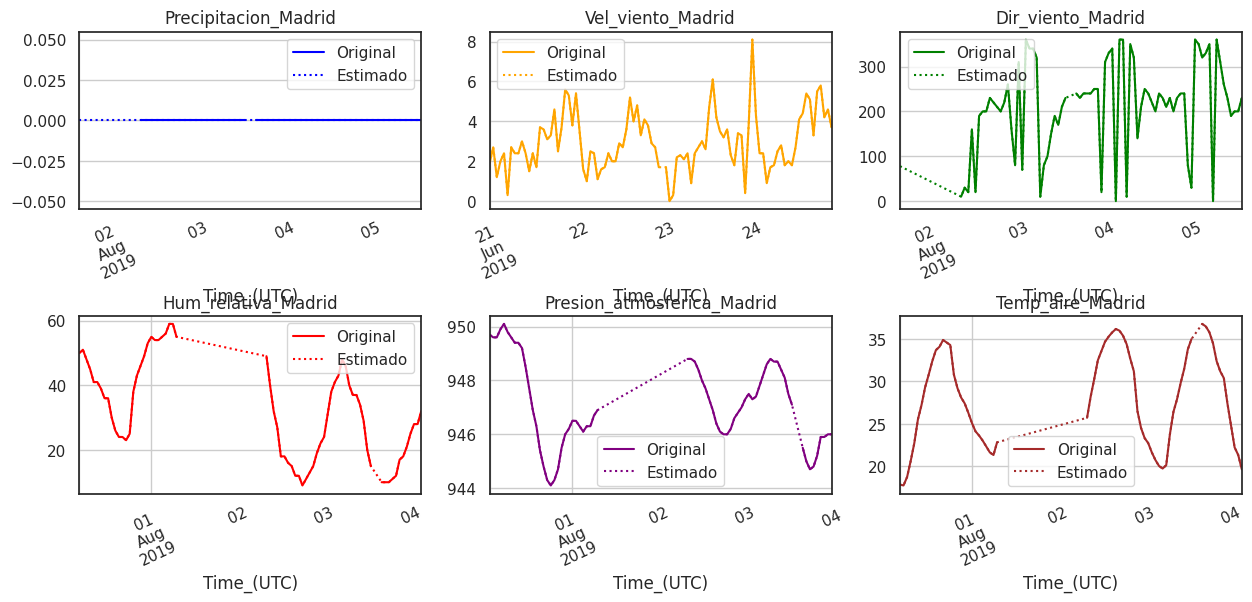

In [75]:
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
i=1
for c in range(1,7):
  n = np.where(train_original.iloc[:,c].isnull())[0][75]
  ax = fig.add_subplot(2, 3, i)
  train_original.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25,label='Original')
  train.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25, label='Estimado', linestyle = ":")
  ax.set_title(train.columns[c])
  plt.legend()
  plt.grid()
  i+=1

Este método funciona bien para cuando hay periodos cortos de datos ausentes (menores a 6h), sin embargo, en espacios más largos de tiempo estamos eliminando la característica periódica de las variables climáticas. Gráficamente observamos que una buena aproximación para este caso es repetir los valores del día anterior, con lo que tenemos.

In [76]:
for i in range(0,len(filas)):
  p=6
  cont = train_original.iloc[filas[i]-p:filas[i]+p+1,columnas[i]].isna().sum()
  if cont>p:
    train.iloc[filas[i],columnas[i]] = np.nan
while train.isna().any().any() == True:
  train = train.fillna(train.shift(24))

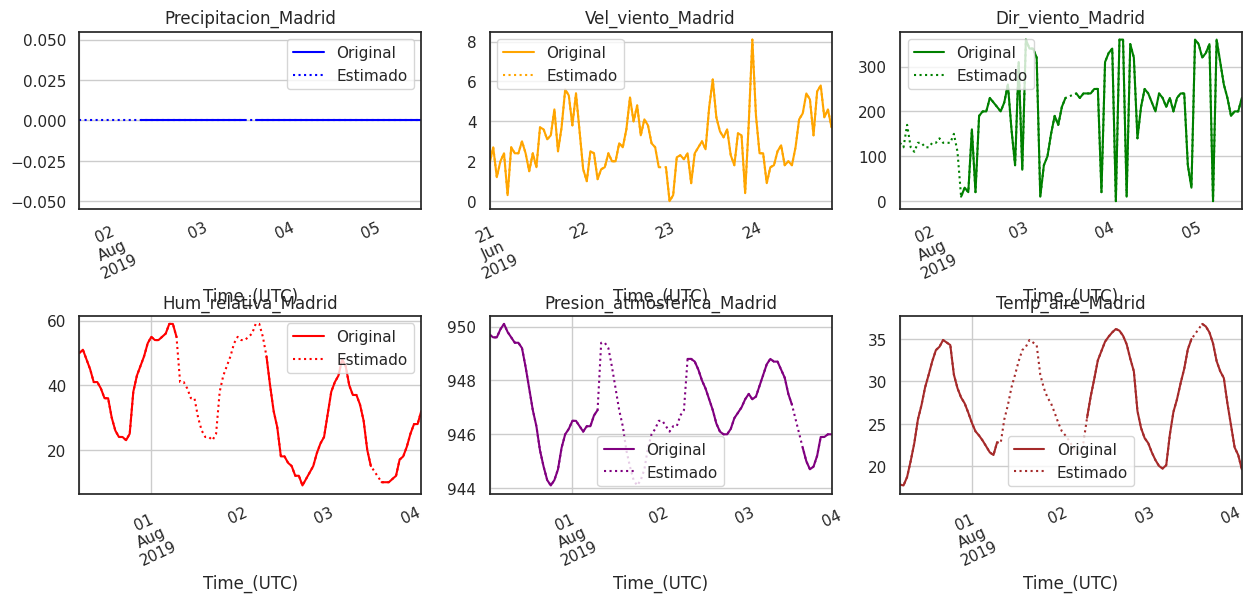

In [77]:
fig = plt.figure(figsize= (15,6))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
i=1
for c in range(1,7):
  n = np.where(train_original.iloc[:,c].isnull())[0][75]
  ax = fig.add_subplot(2, 3, i)
  train_original.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25,label='Original')
  train.iloc[n-48:n+48,c].plot(color=colores[i-1], rot = 25, label='Estimado', linestyle = ":")
  ax.set_title(train.columns[c])
  plt.legend()
  plt.grid()
  i+=1

Los resultados son satisfactorios, por lo tanto, expandimos la estrategia al total de los datos.

In [78]:
datos_original=datos.copy()
a = np.where(datos_original.isnull())
filas = a[0]
columnas = a[1]
datos = datos.interpolate(method='linear', axis =0)
for i in range(0,len(filas)):
  p=6
  cont = datos_original.iloc[filas[i]-p:filas[i]+p+1,columnas[i]].isna().sum()
  if cont>p:
    datos.iloc[filas[i],columnas[i]] = np.nan
while datos.isna().any().any() == True:
  datos = datos.fillna(datos.shift(24))

Comprobamos que el tratamiento de nulos fue exitoso a lo largo de la serie temporal.

In [79]:
for column in datos.columns:
    num_nulls = datos[column].isna().sum()
    print(f'Columna "{column}" tiene {num_nulls} nulos')

Columna "Actual_load" tiene 0 nulos
Columna "Precipitacion_Madrid" tiene 0 nulos
Columna "Vel_viento_Madrid" tiene 0 nulos
Columna "Dir_viento_Madrid" tiene 0 nulos
Columna "Hum_relativa_Madrid" tiene 0 nulos
Columna "Presion_atmosferica_Madrid" tiene 0 nulos
Columna "Temp_aire_Madrid" tiene 0 nulos
Columna "Precipitacion_Barcelona" tiene 0 nulos
Columna "Vel_viento_Barcelona" tiene 0 nulos
Columna "Dir_viento_Barcelona" tiene 0 nulos
Columna "Hum_relativa_Barcelona" tiene 0 nulos
Columna "Presion_atmosferica_Barcelona" tiene 0 nulos
Columna "Temp_aire_Barcelona" tiene 0 nulos
Columna "Precipitacion_Valencia" tiene 0 nulos
Columna "Vel_viento_Valencia" tiene 0 nulos
Columna "Dir_viento_Valencia" tiene 0 nulos
Columna "Hum_relativa_Valencia" tiene 0 nulos
Columna "Presion_atmosferica_Valencia" tiene 0 nulos
Columna "Temp_aire_Valencia" tiene 0 nulos


A continuación se muestran las características estadísticas del conjunto de entrenamiento.

In [80]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Actual_load,33960.0,27485.956125,4401.717090,16144.0,23892.0,27543.0,30849.0,41754.0
Precipitacion_Madrid,33960.0,0.044554,0.390345,0.0,0.0,0.0,0.0,17.4
Vel_viento_Madrid,33960.0,2.839122,2.043029,0.0,1.4,2.2,3.8,17.0
Dir_viento_Madrid,33960.0,203.266343,112.925978,0.0,120.0,210.0,320.0,360.0
Hum_relativa_Madrid,33960.0,58.422659,24.567152,6.0,38.0,59.0,81.0,100.0
Presion_atmosferica_Madrid,33960.0,950.291486,5.748040,925.0,946.8,950.0,953.9,966.3
Temp_aire_Madrid,33960.0,15.903519,9.251214,-12.6,9.1,14.7,22.4,42.4
Precipitacion_Barcelona,33960.0,0.067375,0.883290,0.0,0.0,0.0,0.0,52.7
Vel_viento_Barcelona,33960.0,4.155197,2.232030,0.0,2.7,3.8,5.2,20.6
Dir_viento_Barcelona,33960.0,191.663280,124.346974,0.0,80.0,220.0,310.0,360.0


Los valores se ven homogéneamente distribuidos y no se detecta ningún outlier a simple vista, la variable precipitación muestra baja varianza, lo que no aporta información relevante al modelo. A continuación vemos los histogramas de los datos climáticos de las 3 ciudades.

Text(0.5, 1.0, 'Demanda (MWh)')

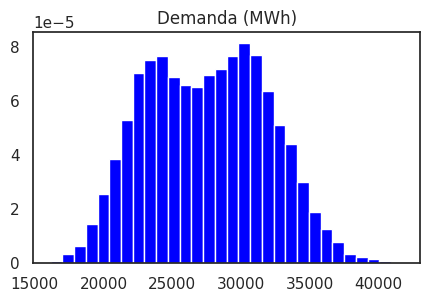

In [81]:
fig = plt.figure(figsize= (5,3))
ax = fig.add_subplot()
ax.hist(train.iloc[:,0], bins=30, color=colores[0], density=True)
ax.set_title("Demanda (MWh)")

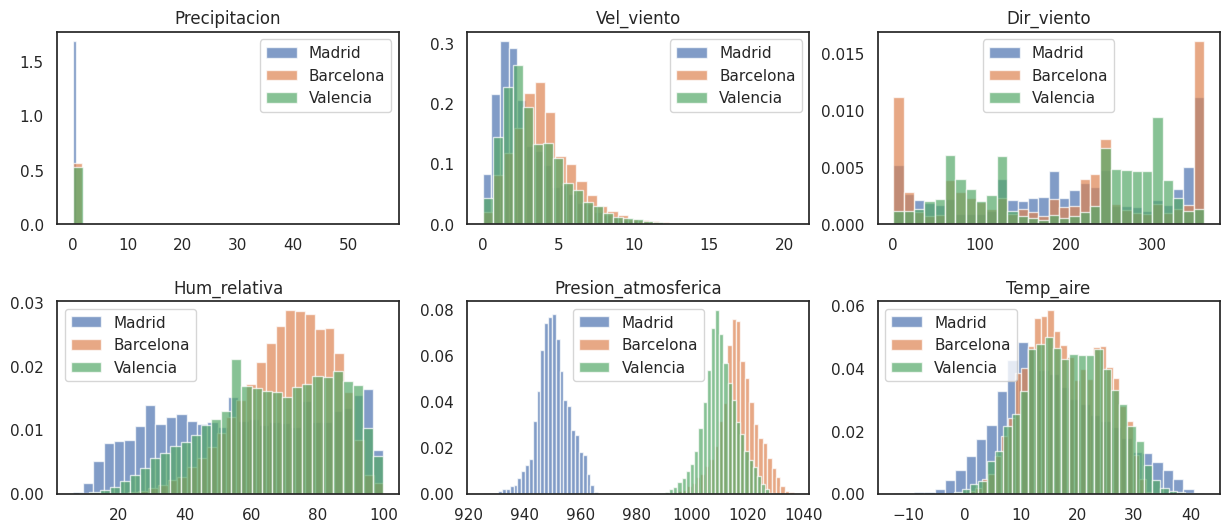

In [82]:
fig = plt.figure(figsize= (15,6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
i=1
for d in range(1,7):
  ax = fig.add_subplot(2, 3, i)
  ax.hist(train.iloc[:,d], bins=30, alpha=0.7, density=True, label='Madrid')
  ax.hist(train.iloc[:,d+6], bins=30, alpha=0.7, density=True, label='Barcelona')
  ax.hist(train.iloc[:,d+12], bins=30, alpha=0.7, density=True, label='Valencia')
  plt.legend()
  ax.set_title(train.columns[d][:-7])
  i+=1

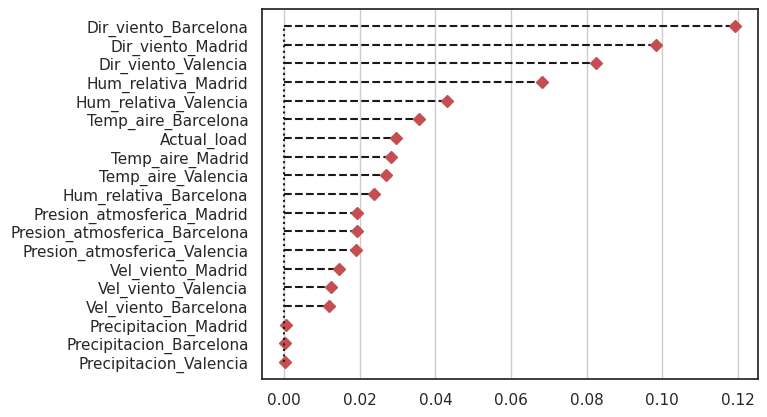

In [83]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Estandarizar las características
scaler = MinMaxScaler()
df_standardized = scaler.fit_transform(train)
df_standardized = pd.DataFrame(df_standardized, columns=train.columns)
R=df_standardized.var().sort_values(ascending=True)
plt.stem(R.index,R,orientation = "horizontal",linefmt = 'k--',markerfmt = 'Dr',basefmt = 'k:')
plt.grid(axis = "x")

## Análisis de la serie de tiempo

Se gráfican los valores de demanda eléctrica en diferentes escalas de tiempo para  observar patrones de tendencia o estacionalidad en el tiempo.

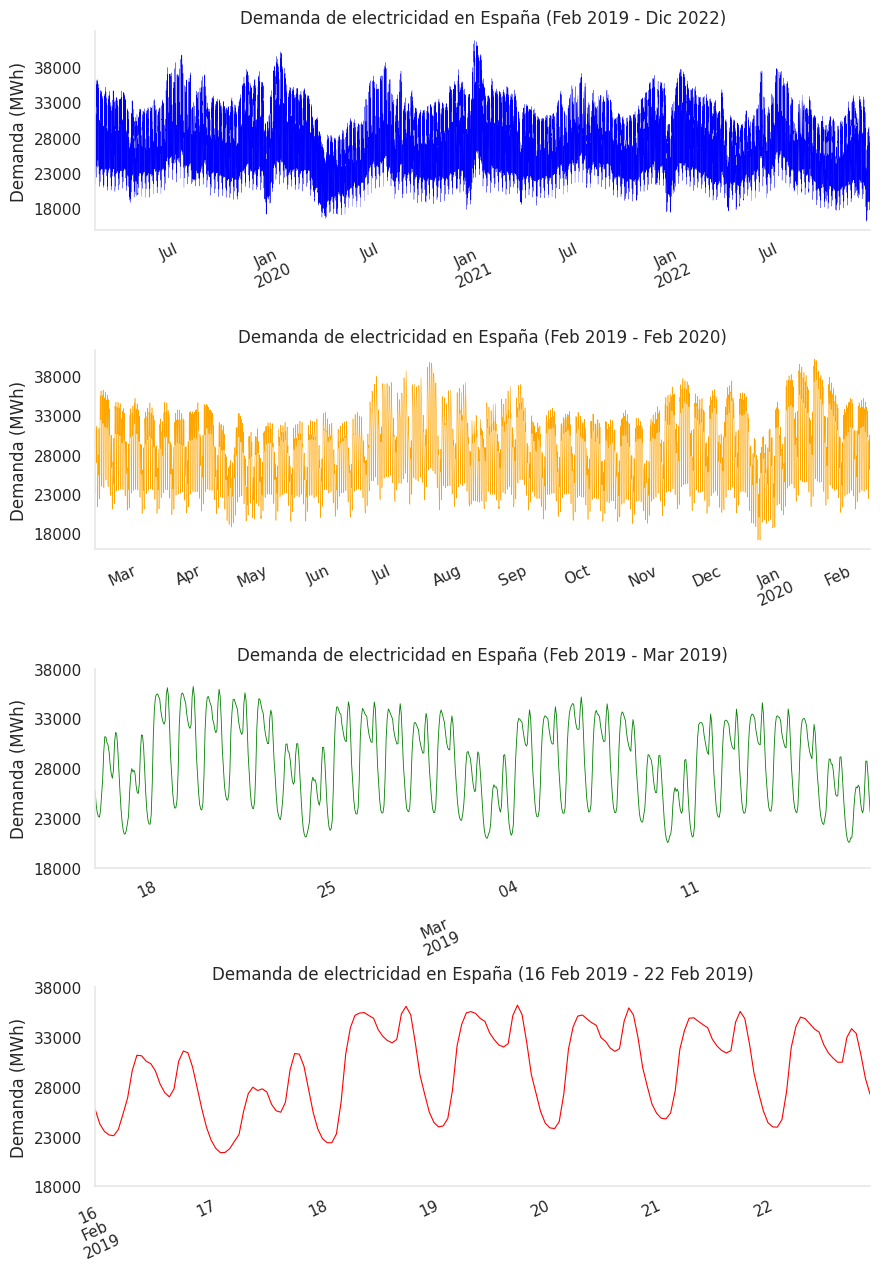

In [84]:
titulos = ["(Feb 2019 - Dic 2022)","(Feb 2019 - Feb 2020)","(Feb 2019 - Mar 2019)","(16 Feb 2019 - 22 Feb 2019)"]
fechas = [len(train),24*365,24*30,24*7]
fig = plt.figure(figsize=(10, 15))
fig.subplots_adjust(hspace=0.6, wspace=0.3)
for i in range(1,5):
  ax = fig.add_subplot(4, 1, i)
  ts = train.iloc[:fechas[i-1],0]
  ts.plot(color=colores[i-1], rot = 25, linewidth=0.2*i)
  ax.set_title("Demanda de electricidad en España " + titulos[i-1])
  ax.set_yticks([y for y in np.arange(18000, 41000, 5000)])
  ax.spines["left"].set_color("#e8e8e8")
  ax.spines["bottom"].set_color("#e8e8e8")
  ax.spines["right"].set_color("none")
  ax.spines["top"].set_color("none")
  plt.ylabel('Demanda (MWh)')
  plt.xlabel('')

Text(0.62, -0.03, '•  Realizado por Ismael Kastillo  •  Fuente: ENTSO-E')

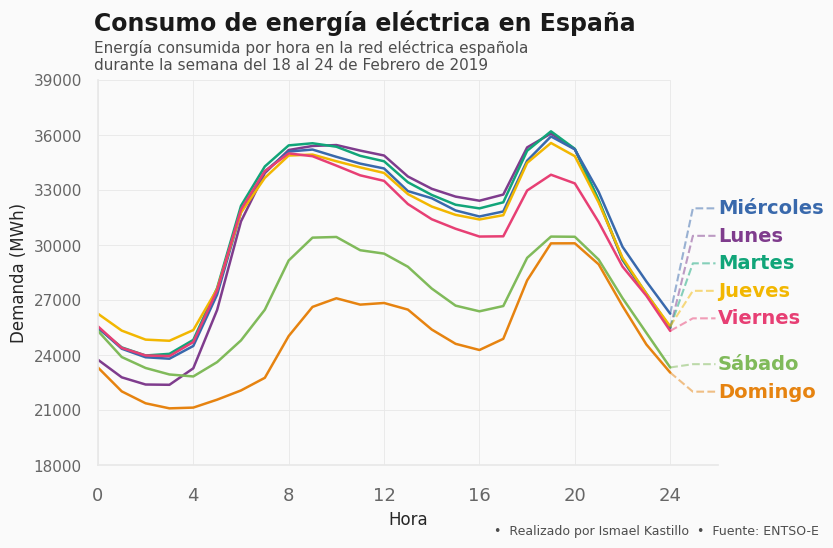

In [85]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"
# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
    GREY50     # USA
]
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (8, 5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
VLINES = np.arange(0, 25, 4)
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 40000, 3000), xmin=0, xmax=24, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=0, xmax=24, color=GREY60, lw=0.8)

# Add lines ------------------------------------------------------
x = [str(h).zfill(2) for h in range(25)]

for i in range(0,7):
  t = 48 + 24*i
  y = list(train.iloc[t:t+25,0])
  color = COLOR_SCALE[i]
  ax.plot(x, y, color=color, lw=1.8)


  # First, adjust axes limits so annotations fit in the plot
ax.set_xlim(0, 26)
ax.set_ylim(20000, 39000)

# Positions
LABEL_Y = [
    30500,  # L
    29000,  # M
    32000,    # X
    27500,   # J
    26000,  # V
    23500,   # S
    22000,  # D
]

x_start = 24
x_end = 26
PAD = 0.1

# Add labels for highlighted countries honly
data = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]
for i in range(0,7):
    color = COLOR_SCALE[i]
    text = data[i]

    t = 48 + 24*i
    y_start = train.iloc[t+24,0]
    # Vertical end of line
    y_end = LABEL_Y[i]

    # Add line based on three points
    ax.plot(
        [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD],
        [y_start, y_end, y_end],
        color=color,
        alpha=0.5,
        ls="dashed"
    )

    # Add country text
    ax.text(
        x_end,
        y_end,
        text,
        color=color,
        fontsize=14,
        weight="bold",
        va="center"
    )


# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.arange(18000, 40000, 3000)])
ax.set_yticklabels(
    [y for y in np.arange(18000, 40000, 3000)],
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(0, 25, 4)])
ax.set_xticklabels(
    [x for x in np.arange(0, 25, 4)],
    fontsize=13,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.ylabel('Demanda (MWh)')
plt.xlabel('Hora')

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "Energía consumida por hora en la red eléctrica española",
    "durante la semana del 18 al 24 de Febrero de 2019",
]

fig.text(
    0.12,
    0.98,
    "Consumo de energía eléctrica en España",
    color=GREY10,
    fontsize=17,
    weight="bold"
)

fig.text(
    0.12,
    0.90,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontsize=11,
)

fig.text(
    0.62,
    -0.03,
    "•  Realizado por Ismael Kastillo  •  Fuente: ENTSO-E",
    fontsize=9,
    color=GREY30,
    ha="left"
)

De los graficos podemos extraer algunas conclusiones respecto a la estacionalidad:
1. No se observa estacionalidad mensual ni anual.
2. Hay estacionalidad semanal.
3. Hay estacionalidad diaria.

Por último vamos a ver los gráficos de autocorrelación para retardos diarios y semanales.

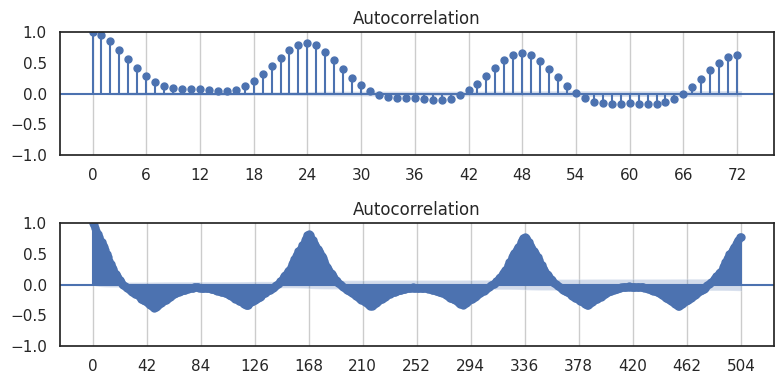

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 4))
plot_acf(train['Actual_load'], lags=24*3, ax=ax1)
ax1.set_xticks([x for x in np.arange(0, 24*3+1, 6)])
ax1.grid(axis = "x")
x = train['Actual_load'].diff(24).dropna()
plot_acf(x, lags=24*7*3, ax=ax2)
ax2.set_xticks([x for x in np.arange(0, 24*7*3+1, 42)])
ax2.grid(axis = "x")
plt.tight_layout()
plt.show()

Se comprueba que la serie de tiempo tiene estacionalidad cada 24 horas y 7 días.

<Axes: >

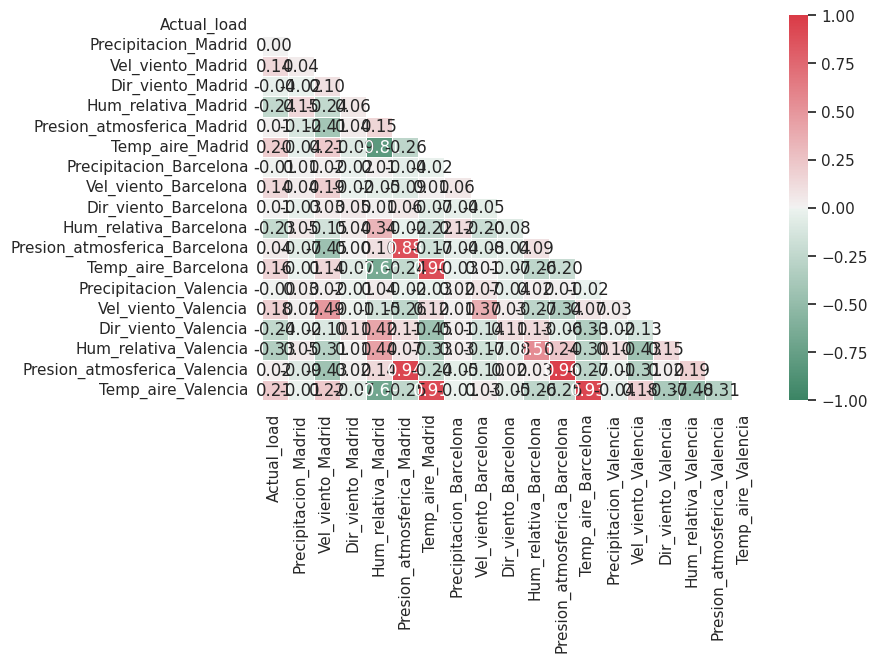

In [87]:
R = train.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.set(style="white")
mask = np.zeros_like(R, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150, 10, as_cmap=True)
sns.heatmap(R, mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.2f', linewidths=.5)

## Ingeniería de características


Empecemos por analizar la variable dirección del viento, se trata de un valores angulares de 0-360 que es un tipo de dato incompatible con los modelos de ML, por lo que vamos a realizar una transformación a coordenadas cartesianas.


In [88]:
for x in ["Madrid", "Barcelona", "Valencia"]:
  train['Viento_x_'+x] = train["Vel_viento_"+x]*np.cos(2*np.pi*train["Dir_viento_"+x]/360)
  train['Viento_y_'+x] = train["Vel_viento_"+x]*np.sin(2*np.pi*train["Dir_viento_"+x]/360)
  train.drop(["Vel_viento_"+x,"Dir_viento_"+x], axis = 1, inplace = True)

Replicamos en todos los datos.

In [89]:
for x in ["Madrid", "Barcelona", "Valencia"]:
  datos['Viento_x_'+x] = datos["Vel_viento_"+x]*np.cos(2*np.pi*datos["Dir_viento_"+x]/360)
  datos['Viento_y_'+x] = datos["Vel_viento_"+x]*np.sin(2*np.pi*datos["Dir_viento_"+x]/360)
  datos.drop(["Vel_viento_"+x,"Dir_viento_"+x], axis = 1, inplace = True)

Como sospechamos en el análisis exploratorio la precipitación es una magnitud con baja varianza y la desechamos del modelo.

In [90]:
train.drop(["Precipitacion_Valencia","Precipitacion_Madrid","Precipitacion_Barcelona"], axis = 1, inplace = True)
datos.drop(["Precipitacion_Valencia","Precipitacion_Madrid","Precipitacion_Barcelona"], axis = 1, inplace = True)

Dibujamos la matriz de correlación entre los predictores y la variable objetivo.

No existe correlación importante entre "Actual_load" y ninguno de los predictores debido a que el problema no es lineal, pero vemos zonas de alta correlación entre variables climáticas. Con el objetivo de eliminar multicolinealidad y reducir dimensiones, se crea un nuevo conjunto de variables climáticas que capten las características de las 3 ciudades tomadas en cuenta en ese estudio. Además de los valores originales del dataset se añaden el promedio y promedio ponderado como candidatos y se elige el de mayor coeficiente de correlación con la variable objetivo.


In [91]:
m, b, v = 3266126, 1636762, 794288
total = m + b + v
train["Hum_relativa_pond"] = (m*train["Hum_relativa_Madrid"]+b*train["Hum_relativa_Barcelona"]+v*train["Hum_relativa_Valencia"])/total
train["Presion_atm_pond"]  = (m*train["Presion_atmosferica_Madrid"]+b*train["Presion_atmosferica_Barcelona"]+v*train["Presion_atmosferica_Valencia"])/total
train["Temp_aire_pond"]    = (m*train["Temp_aire_Madrid"]+b*train["Temp_aire_Barcelona"]+v*train["Temp_aire_Valencia"])/total
train["Viento_x_pond"]     = (m*train["Viento_x_Madrid"]+b*train["Viento_x_Barcelona"]+v*train["Viento_x_Valencia"])/total
train["Viento_y_pond"]     = (m*train["Viento_y_Madrid"]+b*train["Viento_y_Barcelona"]+v*train["Viento_y_Valencia"])/total

train["Hum_relativa_prom"] = (train["Hum_relativa_Madrid"]+train["Hum_relativa_Barcelona"]+train["Hum_relativa_Valencia"])/3
train["Presion_atm_prom"]  = (train["Presion_atmosferica_Madrid"]+train["Presion_atmosferica_Barcelona"]+train["Presion_atmosferica_Valencia"])/3
train["Temp_aire_prom"]    = (train["Temp_aire_Madrid"]+train["Temp_aire_Barcelona"]+train["Temp_aire_Valencia"])/3
train["Viento_x_prom"]     = (train["Viento_x_Madrid"]+train["Viento_x_Barcelona"]+train["Viento_x_Valencia"])/3
train["Viento_y_prom"]     = (train["Viento_y_Madrid"]+train["Viento_y_Barcelona"]+train["Viento_y_Valencia"])/3

In [92]:
train["Hum_relativa_prom"] = (train["Hum_relativa_Madrid"]+train["Hum_relativa_Barcelona"]+train["Hum_relativa_Valencia"])/3
train["Presion_atm_prom"]  = (train["Presion_atmosferica_Madrid"]+train["Presion_atmosferica_Barcelona"]+train["Presion_atmosferica_Valencia"])/3
train["Temp_aire_prom"]    = (train["Temp_aire_Madrid"]+train["Temp_aire_Barcelona"]+train["Temp_aire_Valencia"])/3
train["Viento_x_prom"]     = (train["Viento_x_Madrid"]+train["Viento_x_Barcelona"]+train["Viento_x_Valencia"])/3
train["Viento_y_prom"]     = (train["Viento_y_Madrid"]+train["Viento_y_Barcelona"]+train["Viento_y_Valencia"])/3

A continuación se ven las medias de los índices de correlación ordenados de mayor a menor.

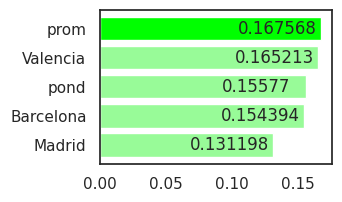

In [93]:
R = abs(train.corr())
R = R.iloc[1:,0:1]
R["Grupo"] = R.index
R['Grupo'] = R["Grupo"].apply(lambda x: x.split('_')[-1])
R = R.groupby('Grupo').mean()["Actual_load"].sort_values(ascending=True)
plt.figure(figsize=(3, 2))
graf = plt.barh(R.index, R, color=["palegreen","palegreen","palegreen","palegreen","lime"])
plt.bar_label(graf, padding=-60)
plt.show()


Se ve que el valor más alto corresponde al promedio de las variables climáticas de Madrid, Barcelona y Valencia.

In [94]:
train.drop(train.iloc[:,1:21].columns, axis = 1, inplace = True)

In [95]:
datos["Hum_relativa_prom"] = (datos["Hum_relativa_Madrid"]+datos["Hum_relativa_Barcelona"]+datos["Hum_relativa_Valencia"])/3
datos["Presion_atm_prom"]  = (datos["Presion_atmosferica_Madrid"]+datos["Presion_atmosferica_Barcelona"]+datos["Presion_atmosferica_Valencia"])/3
datos["Temp_aire_prom"]    = (datos["Temp_aire_Madrid"]+datos["Temp_aire_Barcelona"]+datos["Temp_aire_Valencia"])/3
datos["Viento_x_prom"]     = (datos["Viento_x_Madrid"]+datos["Viento_x_Barcelona"]+datos["Viento_x_Valencia"])/3
datos["Viento_y_prom"]     = (datos["Viento_y_Madrid"]+datos["Viento_y_Barcelona"]+datos["Viento_y_Valencia"])/3

datos.drop(datos.iloc[:,1:16].columns, axis = 1, inplace = True)

Del análisis de la serie de tiempo sabemos que es se debe tomar en cuenta la estacionalidad de 24 horas y 7 días, por lo tanto, incluímos las trasformaciones senoidales y cosenoidales de la hora y el día de la semana, esto porque así se expresa de mejor manera el comportamiento periódico del tiempo.

In [96]:
hora = train.index.hour
dia = 24*train.index.weekday + hora
train['sin_hora'] = np.sin(2*np.pi*hora/24)
train['cos_hora'] = np.cos(2*np.pi*hora/24)
train['sin_dia'] = np.sin(2*np.pi*dia/(24*7))
train['cos_dia'] = np.cos(2*np.pi*dia/(24*7))

In [97]:
hora = datos.index.hour
dia = 24*datos.index.weekday + hora
datos['sin_hora'] = np.sin(2*np.pi*hora/24)
datos['cos_hora'] = np.cos(2*np.pi*hora/24)
datos['sin_dia'] = np.sin(2*np.pi*dia/(24*7))
datos['cos_dia'] = np.cos(2*np.pi*dia/(24*7))


Ahora se tiene un conjunto de predictores más pequeño pero más robusto, lo comprobamos con la matriz de correlación.

<Axes: >

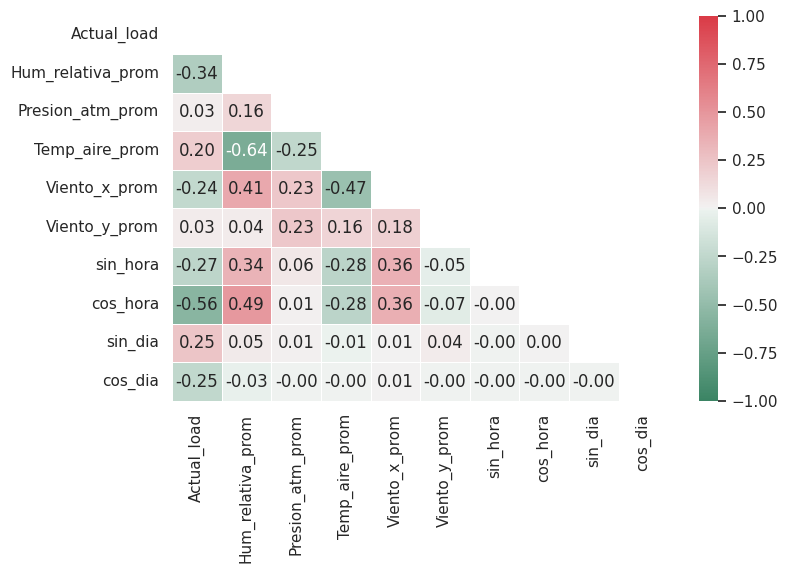

In [98]:
R = train.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.set(style="white")
mask = np.zeros_like(R, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(150, 10, as_cmap=True)
sns.heatmap(R, mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.2f', linewidths=.5)

Finalmente separamos la variable objetivo de los predictores.

In [99]:
x_datos = datos.iloc[:,1:]
y_datos = datos['Actual_load']

In [100]:
print(len(datos))
print(fin_train)
print(len(train))


47088
33960
33960
